In [1]:
import ehrapy.api as ep
import spacy
import pandas as pd

Unable to contact PyPI to check for the latest ehrapy version. Do you have an internet 
connection?

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/medcat/cat.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ep.settings.n_jobs=8

In [3]:
# !python -m spacy download en_core_web_sm

In [4]:
# !wget https://medcat.rosalind.kcl.ac.uk/media/vocab.dat -P ./medcat_data/
# !wget https://medcat.rosalind.kcl.ac.uk/media/cdb-medmen-v1_2.dat -P ./medcat_data/
# !wget https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./medcat_data/
# !wget https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip -P ./medcat_data/

# Custom MedCAT object

In [5]:
# Mind your dependencies and environments. This may clash with existing Spacy models!
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [6]:
medcat = ep.tl.MedCAT()

vocabulary = medcat.load_vocabulary("./medcat_data/vocab.dat")
concept_db = medcat.load_concept_db("./medcat_data/cdb-medmen-v1.dat")

concept_db.config.ner['min_name_len'] = 2
concept_db.config.ner['upper_case_limit_len'] = 3
concept_db.config.general['spell_check'] = True
concept_db.config.linking['train_count_threshold'] = 10
concept_db.config.linking['similarity_threshold'] = 0.3
concept_db.config.linking['train'] = True
concept_db.config.linking['disamb_length_limit'] = 5
concept_db.config.general['full_unlink'] = True

medcat.update_cat(vocabulary=vocabulary, concept_db=concept_db)

In [7]:
text = "He was diagnosed with kidney failure"
doc = medcat.cat(text)
doc.ents

(diagnosed, kidney failure)

In [8]:
medcat.cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {0: {'pretty_name': 'Diagnosis',
   'cui': 'C0011900',
   'type_ids': ['T060'],
   'types': ['Diagnostic Procedure'],
   'source_value': 'diagnosed',
   'detected_name': 'diagnosed',
   'acc': 0.3913008909798732,
   'context_similarity': 0.3913008909798732,
   'start': 7,
   'end': 16,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 0,
   'meta_anns': {}},
  2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'type_ids': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {}}},
 'tokens': []}

# Extracting disease entities from an existing dataset

In [3]:
data = pd.read_csv("./medcat_data/pt_notes.csv")

In [4]:
data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
0,6,1,2079-01-01,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
1,7,1,2079-01-01,Rheumatology,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079,1,F,2018-01-01,2018,61
2,8,1,2079-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
3,9,2,2037-01-01,Consult - History and Phy.,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037,2,F,2018-01-01,2018,19
4,10,2,2037-01-01,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037,2,F,2018-01-01,2018,19


In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data["text"][0])

HISTORY OF PRESENT ILLNESS:, The patient is a 71-year-old Caucasian female with a history of diabetes, osteoarthritis, atrial fibrillation, hypertension, asthma, obstructive sleep apnea on CPAP, diabetic foot ulcer, anemia and left lower extremity cellulitis. She was brought in by the EMS service to Erlanger emergency department with pulseless electrical activity. Her husband states that he was at home with his wife, when she presented to him complaining of fever and chills. She became acutely unresponsive. She was noted to have worsening of her breathing. She took several of her MDIs and then was placed on her CPAP. He went to notify EMS and when he returned, she was found to not be breathing. He stated that she was noted to have no breathing in excess of 10 minutes. He states that the EMS system arrived at the home and she was found not breathing. The patient was intubated at the scene and upon arrival to Erlanger Medical Center, she was found to have pupils fixed and dilated. She wa

In [6]:
adata = ep.io.read("medcat_data/pt_notes.csv", columns_obs_only=["subject_id", "chartdate", "text", "dob_year"])

In [7]:
medcat = ep.tl.MedCAT(model_pack_path="medcat_data/medmen_wstatus_2021_oct.zip")
medcat.concept_db = medcat.cat.cdb

Found an existing unziped model pack at: medcat_data/medmen_wstatus_2021_oct, the provided zip will not be touched.


In [8]:
medcat.concept_db = medcat.filter_tui(medcat.concept_db, ['T047', 'T048'])

The size of the concept database is now: 1763

In [9]:
annotation = medcat.annotate(adata.obs.text)

Output()

Annotated until now: 0 docs; Current BS: 157 docs; Elapsed time: 0.00 minutes
Annotated until now: 157 docs; Current BS: 165 docs; Elapsed time: 1.32 minutes
Annotated until now: 322 docs; Current BS: 151 docs; Elapsed time: 2.58 minutes
Annotated until now: 473 docs; Current BS: 160 docs; Elapsed time: 3.84 minutes
Annotated until now: 633 docs; Current BS: 152 docs; Elapsed time: 5.01 minutes
Annotated until now: 785 docs; Current BS: 130 docs; Elapsed time: 6.18 minutes
Annotated until now: 915 docs; Current BS: 157 docs; Elapsed time: 7.17 minutes
Annotated until now: 1072 docs; Current BS: 16 docs; Elapsed time: 8.06 minutes


In [10]:
adata.obs["diagnoses"] = annotation.entities_pretty.values()

In [11]:
adata.obs.diagnoses[0]

['Diabetes',
 'Degenerative polyarthritis',
 'Atrial Fibrillation',
 'Hypertensive disease',
 'Asthma',
 'Sleep Apnea, Obstructive',
 'Diabetic foot ulcer',
 'Anemia',
 'Diabetes',
 'Degenerative polyarthritis',
 'Hypertensive disease',
 'Asthma',
 'Atrial Fibrillation',
 'Diabetic foot ulcer',
 'Anemia',
 'Coronary Arteriosclerosis',
 'Cardiac Arrest',
 'Respiratory Failure',
 'Pulmonary Embolism',
 'Myocardial Infarction',
 'Respiratory Distress Syndrome, Adult',
 'Sepsis']

In [12]:
subjects_diseases_pcts = medcat.calculate_disease_proportions(adata,
                                                              annotation.cui_locations,
                                                              subject_id_col="subject_id")

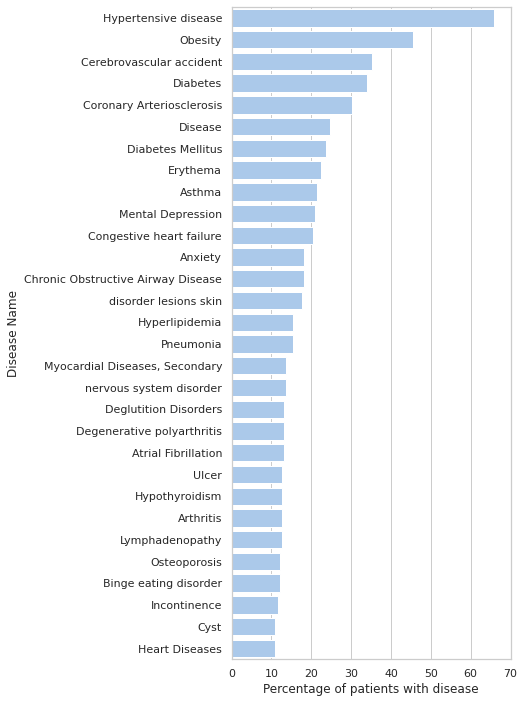

In [13]:
medcat.plot_top_diseases(subjects_diseases_pcts, 30)